# Example-12: TM010 cavity factory

In this example cavity factory is illustrated. 

The TM010 cavity hamiltonian is:

$
\begin{align}
& H(q_x, q_y, q_s, p_x, p_y, p_s; s) = \frac{p_s}{\beta} - t(s)(q_x p_y - q_y p_x) - (1 + h(s) q_x) \left(\sqrt{P_s^2 - P_x^2 - P_y^2 - \frac{1}{\beta^2 \gamma^2}} + a_s(q_x, q_y, q_s; s)\right)  \\
& \\
& P_s = p_s + 1/\beta - \varphi(q_x, q_y, q_s; s)  \\
& P_x = p_x - a_x(q_x, q_y, q_s; s)  \\
& P_y = p_y - a_y(q_x, q_y, q_s; s) \\
\\
& (a_x, a_y, a_s) = (0, 0, \frac{q E}{P \omega} J(k r) \cos(k\left(\frac{s}{\beta} - q_s \right) + \phi))\\
& r^2 = q_x^2 + q_y^2
& \\
& \varphi = 0 \\
& t = h = 0 \\
\end{align}
$

The constructed element signature is:

```python
# kick
def cavity(qsps:Array, length:Array, kn:Array, ks:Array) -> Array:
    ...

# main
def cavity(qsps:Array, length:Array, kn:Array, ks:Array) -> Array:
    ...
```

Note, by default only energy kick is performed and cavity has zero length.

In [1]:
import jax
from jax import jit
from jax import jacrev

from elementary.util import ptc
from elementary.util import CL
from elementary.util import ME
from elementary.util import beta
from elementary.util import gamma
from elementary.util import rigidity

from elementary.cavity import cavity_factory

from matplotlib import pyplot as plt

jax.numpy.set_printoptions(linewidth=256, precision=12)

In [2]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [3]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [4]:
# Define cavity elements

gamma = 1000.0

element_kick = jit(cavity_factory(rigidity(beta(gamma), gamma, ME, 1), kind='kick', beta=beta(gamma), gamma=gamma, order=2**1, iterations=100))
element_main = jit(cavity_factory(rigidity(beta(gamma), gamma, ME, 1), kind='main', beta=beta(gamma), gamma=gamma, order=2**1, iterations=100))

In [5]:
# Set zero initial condition

(q_x, q_y, q_s) = qs = jax.numpy.array([0., 0., 0.])
(p_x, p_y, p_s) = ps = jax.numpy.array([0., 0., 0.])
qsps = jax.numpy.hstack([qs, ps])

In [6]:
# Set parameters

length = jax.numpy.float64(1.0)
voltage = jax.numpy.float64(5.0E+5)*1E-6
frequency = jax.numpy.float64(2.0E+08)*1E-6
lag = jax.numpy.float64(90*jax.numpy.pi/180)

In [7]:
# Compute energy gain

print((1E+6*voltage)/(rigidity(beta(gamma), gamma, ME, 1)*CL)*jax.numpy.sin(lag))

0.0009784760796965218


In [8]:
# Compare with PTC

print(element_kick(qsps, voltage, lag))
print(element_main(qsps, length, voltage, frequency, lag))

print(ref := ptc(qsps, 'rfcavity', {'l': float(length), 'no_cavity_totalpath': 'true', 'n_bessel': 10, 'freq': float(frequency), 'volt': float(voltage), 'lag': float(lag/(2*jax.numpy.pi))}, gamma=gamma))
print()

[0.            0.            0.            0.            0.            0.00097847608]
[-1.082847985127e-18 -1.082847985127e-18  4.885907984818e-10 -1.490078219212e-21 -1.490078219212e-21  9.784760807539e-04]
[0.000000000000e+00 0.000000000000e+00 4.887602574200e-10 0.000000000000e+00 0.000000000000e+00 9.784760810177e-04]



In [9]:
# Differentiability

matrix = jax.jacrev(element_main)(qsps, length, voltage, frequency, lag)

print(matrix)
print(jax.numpy.linalg.det(matrix))

[[ 9.989171520149e-01 -5.721517742631e-20 -4.295716685495e-18  9.995109978134e-01 -1.059978537520e-20  1.082475290913e-18]
 [-5.721517742631e-20  9.989171520149e-01 -4.295716685495e-18 -1.059978537520e-20  9.995109978134e-01  1.082475290913e-18]
 [-1.493632396068e-21 -1.493632396068e-21  9.999999978367e-01  1.082158489132e-18  1.082158489132e-18  9.985358733929e-07]
 [-1.490078219213e-06  6.105199573872e-20 -8.596042621954e-18  1.001082530852e+00  7.757678047506e-21  1.485053344709e-21]
 [ 6.105199573872e-20 -1.490078219213e-06 -8.596042621954e-18  7.757678047506e-21  1.001082530852e+00  1.485053344710e-21]
 [-8.586740834050e-18 -8.586740834050e-18 -6.769838121622e-12 -4.291472216269e-18 -4.291472216269e-18  1.000000002163e+00]]
1.0


In [10]:
# Scan initial lag

lags = 2*jax.numpy.pi*jax.numpy.linspace(0.0, 1.0, 101) ;

out_kick = [element_kick(qsps, voltage, lag) for lag in lags]
*_, out_kick = jax.numpy.stack(out_kick).T

out_main = [element_main(qsps, length, voltage, frequency, lag) for lag in lags]
*_, out_main = jax.numpy.stack(out_main).T

out_ptc = [ptc(qsps, 'rfcavity', {'no_cavity_totalpath': 'true', 'l': float(length), 'n_bessel': 10, 'freq': float(frequency), 'volt': float(voltage), 'lag': float(lag/(2*jax.numpy.pi))}, gamma=gamma) for lag in lags]
*_, out_ptc = jax.numpy.stack(out_ptc).T

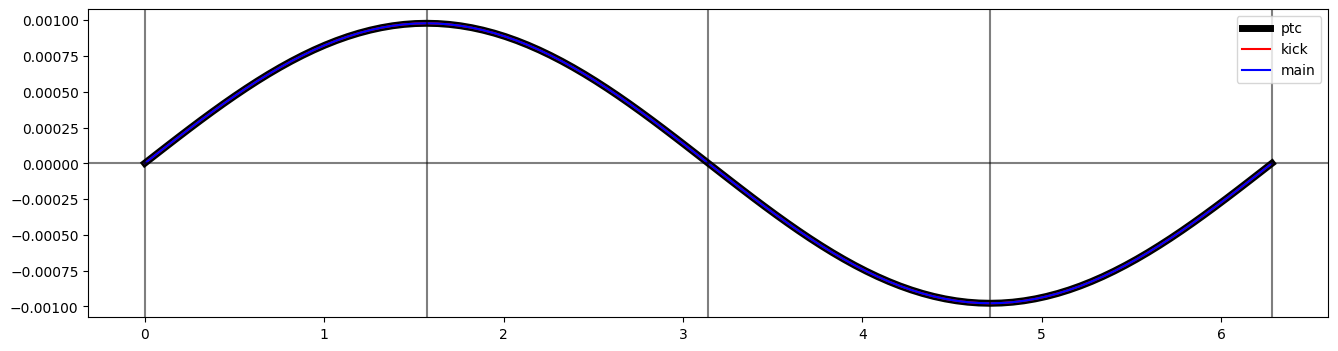

In [11]:
# Plot energy change vs lag

plt.figure(figsize=(16, 4))
plt.plot(lags, out_ptc, color='black', label='ptc', lw=5)
plt.plot(lags, out_kick, color='red', label='kick')
plt.plot(lags, out_main, color='blue', label='main')
plt.gca().axhline(0, color='black', alpha=0.5)
plt.gca().axvline(0, color='black', alpha=0.5)
plt.gca().axvline(jax.numpy.pi/2, color='black', alpha=0.5)
plt.gca().axvline(jax.numpy.pi, color='black', alpha=0.5)
plt.gca().axvline(3*jax.numpy.pi/2, color='black', alpha=0.5)
plt.gca().axvline(2*jax.numpy.pi, color='black', alpha=0.5)
plt.legend()
plt.show()

In [12]:
# Set non-zero initial condition

(q_x, q_y, q_s) = qs = jax.numpy.array([0., 0., -0.001])
(p_x, p_y, p_s) = ps = jax.numpy.array([0.001, 0.001, 0.0001])
qsps = jax.numpy.hstack([qs, ps])

In [13]:
# Set parameters

length = jax.numpy.float64(1.0)
voltage = jax.numpy.float64(5.0E+5)*1E-6
frequency = jax.numpy.float64(2.0E+08)*1E-6
lag = jax.numpy.float64(90*jax.numpy.pi/180)

In [14]:
# Compute energy gain

print((1E+6*voltage)/(rigidity(beta(gamma), gamma, ME, 1)*CL)*jax.numpy.sin(lag))

0.0009784760796965218


In [15]:
# Compare with PTC

print(element_kick(qsps, voltage, lag))
print(element_main(qsps, length, voltage, frequency, lag))

print(ref := ptc(qsps, 'rfcavity', {'l': float(length), 'no_cavity_totalpath': 'true', 'n_bessel': 10, 'freq': float(frequency), 'volt': float(voltage), 'lag': float(lag/(2*jax.numpy.pi))}, gamma=gamma))
print()

[ 0.             0.            -0.001          0.001          0.001          0.00107847608]
[ 0.00099941211   0.00099941211  -0.001000998234  0.001001086708  0.001001086708  0.001078463202]
[ 0.000999412549  0.000999412549 -0.001000998237  0.001000001075  0.001000001075  0.001078466761]

